# Imports

In [146]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

# Load Data

In [154]:
path = 'data/mnist/'

In [149]:
import os
os.makedirs(path, exist_ok=True)

In [150]:
URL = 'http://deeplearning.net/data/mnist/'
FILENAME = 'mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [155]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), _) = load_mnist(path+FILENAME)

In [156]:
type(x), x.shape, type(y), y.shape

(numpy.ndarray, (50000, 784), numpy.ndarray, (50000,))

# Normalize Data

In [157]:
mean = x.mean()
std = x.std()

In [158]:
x = (x - mean) / std
mean, std, x.mean(), x.std()

(0.13044983, 0.3072898, -3.1638146e-07, 0.99999934)

In [159]:
x_valid = (x_valid-mean) / std
x_valid.mean(), x_valid.std()

(-0.005850922, 0.99243325)

In [160]:
x_valid.shape

(10000, 784)

In [181]:
def show(img, title=None):
    plt.imshow(img, cmap="GnBu_r")
    if title is not None: plt.title(title)
        
def plots(ims, figsize=(12, 6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims) // rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], cmap='GnBu_r')

### Plots

In [182]:
x_valid.shape

(10000, 784)

In [183]:
x_imgs = np.reshape(x_valid, (-1, 28, 28)); x_imgs.shape

(10000, 28, 28)

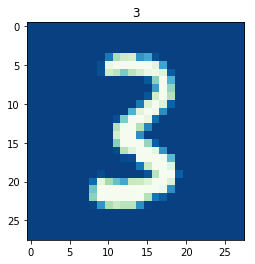

In [184]:
show(x_imgs[0], y_valid[0])

In [185]:
y_valid.shape

(10000,)

In [186]:
y_valid[0]

3

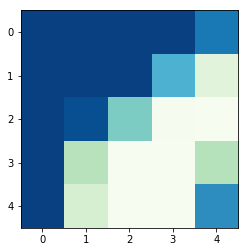

In [187]:
show(x_imgs[0,10:15,10:15])

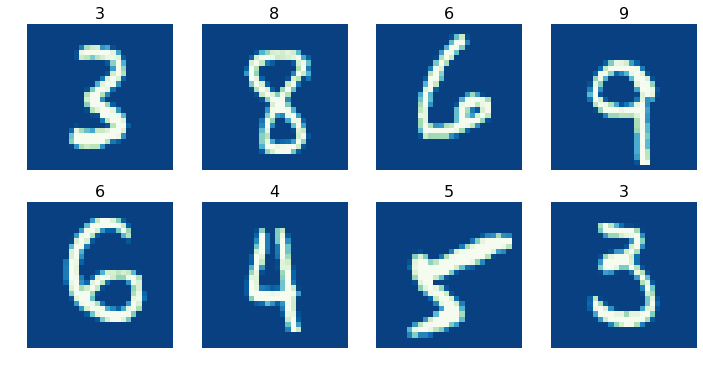

In [188]:
plots(x_imgs[:8], titles=y_valid[:8])

# Neural Net

In [176]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *

import torch.nn as nn

In [189]:
net = nn.Sequential(
    nn.Linear(28*28, 10),
    nn.LogSoftmax()
)

In [190]:
md = ImageClassifierData.from_arrays(path, (x, y), (x_valid, y_valid))

In [191]:
x.shape

(50000, 784)

In [192]:
loss = nn.NLLLoss()
metrics = [accuracy]
opt=optim.Adam(net.parameters())

In [195]:
fit(net, md, n_epochs=4, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.271969   0.270325   0.9274    
    1      0.267552   0.263088   0.9293    
    2      0.287352   0.268897   0.9252    
    3      0.250623   0.272649   0.9268    



[0.27264907078742984, 0.9268]

In [196]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [197]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018

In [198]:
preds = predict(net, md.val_dl)

In [199]:
preds.shape

(10000, 10)

In [200]:
preds.argmax(axis=1)[:5]

array([3, 8, 6, 9, 6])

In [201]:
preds = preds.argmax(1)
np.mean(preds == y_valid)

0.9268

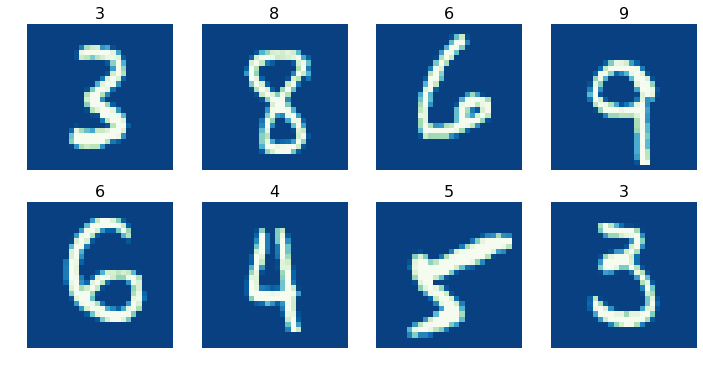

In [202]:
plots(x_imgs[:8], titles=preds[:8])

In [203]:
def get_weights(*dims): return nn.Parameter(torch.randn(dims)/dims[0])
def softmax(x): return torch.exp(x)/(torch.exp(x).sum(dim=1)[:, None])

In [213]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)
        self.l1_b = get_weights(10)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = (x @ self.l1_w + self.l1_b)
        x = torch.log(softmax(x))
        return x

In [214]:
net2 = LogReg()
opt=optim.Adam(net2.parameters())

In [215]:
fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.315365   0.291174   0.9143    



[0.29117408984899523, 0.9143]

In [216]:
dl = iter(md.trn_dl)

In [217]:
xmb, ymb = next(dl)

In [218]:
vxmb = Variable(xmb)
vxmb

tensor([[-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        ...,
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245],
        [-0.4245, -0.4245, -0.4245,  ..., -0.4245, -0.4245, -0.4245]])

In [219]:
preds = net2(vxmb).exp(); preds[:3]

tensor([[8.6197e-06, 1.0029e-05, 1.6249e-03, 1.0714e-05, 4.7166e-03, 2.9150e-04,
         9.9279e-01, 6.9245e-05, 5.1237e-05, 4.2992e-04],
        [9.7017e-06, 5.6883e-07, 2.9247e-04, 1.6272e-04, 9.8068e-01, 1.9494e-03,
         1.8671e-04, 3.3276e-03, 1.0797e-03, 1.2307e-02],
        [1.4663e-03, 6.2781e-01, 1.7878e-02, 2.9407e-01, 2.5712e-03, 1.2008e-02,
         1.9512e-04, 1.5990e-02, 2.0205e-02, 7.8062e-03]],
       grad_fn=<SliceBackward>)

In [222]:
net = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax()
)

In [223]:
fit(net, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      2.300871   2.30122    0.1       



[2.3012197647094728, 0.1]

# Broadcasting

In [101]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7]) 
a, b

(array([10,  6, -4]), array([2, 8, 7]))

In [102]:
a + b

array([12, 14,  3])

In [103]:
a < b

array([False,  True,  True])

In [104]:
(a < b).mean()

0.6666666666666666

In [105]:
a 

array([10,  6, -4])

In [106]:
a > 0

array([ True,  True, False])

In [107]:
a + 1

array([11,  7, -3])

In [108]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [109]:
2 * m

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [110]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [111]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [112]:
c.shape

(3,)

In [113]:
np.expand_dims(c, 0).shape

(1, 3)

In [114]:
m + np.expand_dims(c, 0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [115]:
c[None].shape

(1, 3)

In [116]:
np.expand_dims(c, 1).shape

(3, 1)

In [117]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [118]:
c[:,None].shape

(3, 1)

In [119]:
c[None,:,None].shape

(1, 3, 1)

In [120]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [121]:
np.broadcast_to(c, m.shape)

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [122]:
np.broadcast_to(c[:None], m.shape)

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [124]:
m.shape, c.shape

((3, 3), (3,))

In [125]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 10)  # Layer 1 weights
        self.l1_b = get_weights(10)         # Layer 1 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = x @ self.l1_w + self.l1_b 
        return torch.log(softmax(x))

In [128]:
net2 = LogReg()
opt=optim.Adam(net2.parameters())

fit(net2, md, n_epochs=1, crit=loss, opt=opt, metrics=metrics)

epoch      trn_loss   val_loss   accuracy   
    0      0.343895   0.618298   0.9128    



[0.6182977947235108, 0.9128]

In [129]:
dl = iter(md.trn_dl)

In [131]:
xt, yt = next(dl)
y_pred = net2(Variable(xt))

In [133]:
l = loss(y_pred, Variable(yt))
print(l)

tensor(0.4826, grad_fn=<NllLossBackward>)


In [139]:
def score(x, y):
    y_pred = to_np(net2(V(x)))
    return np.sum(y_pred.argmax(axis=1) == to_np(y))/len(y_pred)


In [145]:
net2 = LogReg()
loss = nn.NLLLoss()
learning_rate = 1e-2
optimizer = optim.SGD(net2.parameters(), lr=learning_rate)

for epoch in range(1):
    losses = []
    dl = iter(md.trn_dl)
    for (*_, t) in dl:
        xt, yt = next(dl)
        y_pred = net2(V(xt))
        l = loss(y_pred, V(yt))
        losses.append(l)
        
        optimizer.zero_grad()
        
        l.backward()
        
        optimizer.step()
    
    val_dl = iter(md.val_dl)
    try:
        val_scores = [score(*next(val_dl)) for i, _ in enumerate(val_dl)]
        print(np.mean(val_scores))
    except StopIteration:
        pass

In [143]:
md.val_dl

In [144]:
??fit

Signature:
fit(
    ['model', 'data', 'n_epochs', 'opt', 'crit', 'metrics=None', 'callbacks=None', "stepper=<class 'fastai.model.Stepper'>", 'swa_model=None', 'swa_start=None', 'swa_eval_freq=None', 'visualize=False', '**kwargs'],
)
Source:   
def fit(model, data, n_epochs, opt, crit, metrics=None, callbacks=None, stepper=Stepper,
        swa_model=None, swa_start=None, swa_eval_freq=None, visualize=False, **kwargs):
    """ Fits a model

    Arguments:
       model (model): any pytorch module
           net = to_gpu(net)
       data (ModelData): see ModelData class and subclasses (can be a list)
       opts: an optimizer. Example: optim.Adam. 
       If n_epochs is a list, it needs to be the layer_optimizer to get the optimizer as it changes.
       n_epochs(int or list): number of epochs (or list of number of epochs)
       crit: loss function to optimize. Example: F.cross_entropy
    """

    seq_first = kwargs.pop('seq_first', False)
    all_val = kwargs.pop('all_val', False)
    g